This is a part of course project done in the fulfillment of the machine learning course offered at Udacity. I was asked to choose one interesting dataset to explore the performance of various supervised machine learning algorithms. Since I like both image processing and machine learning, I wanted to choose something that dealt with images. I don't want it to be too complex, and I found this interesting dataset of [Labeled Faces in the Wild](http://vis-www.cs.umass.edu/lfw/). 

The Labeled Faces in the Wild dataset contains faces of 5749 individuals (4263 male, 1486 female) collected from the web using a Viola-Jones face detector. Of these there are 1680 people for which more than one image is available. This results in 10256 male images and 2977 female images. These color images have an resolution of 250x250. From a machine learning prespective, it is very interesting and it has real-world applications right now. It is multi-class image classification task which is quite relevant and useful. Moreover, folks at scikit-learn included them in their datasets, and even provided a [code base](http://scikit-learn.org/stable/datasets/labeled_faces.html) to start with.

** Note:**  After implementing a few supervised learning methods, I observed that this is a challenging dataset requiring a lot of computing resources with all the data. I've confined the original data to a subset of images containing at least 45 images per person. This ended up decreasing the initial dataset into a 14 class classification problem.

Facebook achieved 97.3% accuracy on the original dataset. Link [here](https://research.facebook.com/publications/deepface-closing-the-gap-to-human-level-performance-in-face-verification/). It requires 120 million parameter tuning and deep neural networks.

## Importing the libraries

In [1]:
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.datasets import fetch_lfw_people
import numpy as np
%pylab inline
pylab.rcParams['figure.figsize'] = (12, 10)
from sklearn.preprocessing import scale
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.decomposition import RandomizedPCA
from sklearn.neighbors import KNeighborsClassifier
plt.style.use('ggplot')
from sklearn.tree import DecisionTreeClassifier

Populating the interactive namespace from numpy and matplotlib


### Importing the data

1. Data is cropped 
2. Images with more than 60 faces per person were selected

In [2]:
lfw_people = fetch_lfw_people(resize= 0.4, min_faces_per_person= 45, color= False)

In [3]:
n_samples, h, w = lfw_people.images.shape
print n_samples, h, w 

1657 50 37


As a result, we have a manageable dataset to train different algorithms

In [4]:
X = lfw_people.data
n_features = X.shape[1]

In [5]:
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

### Exploring the images

In [6]:
print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)
print target_names

Total dataset size:
n_samples: 1657
n_features: 1850
n_classes: 14
['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Jacques Chirac' 'Jean Chretien'
 'John Ashcroft' 'Junichiro Koizumi' 'Luiz Inacio Lula da Silva'
 'Serena Williams' 'Tony Blair' 'Vladimir Putin']


In [7]:
def plot_gallery(images, titles, h, w, n_row=5, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

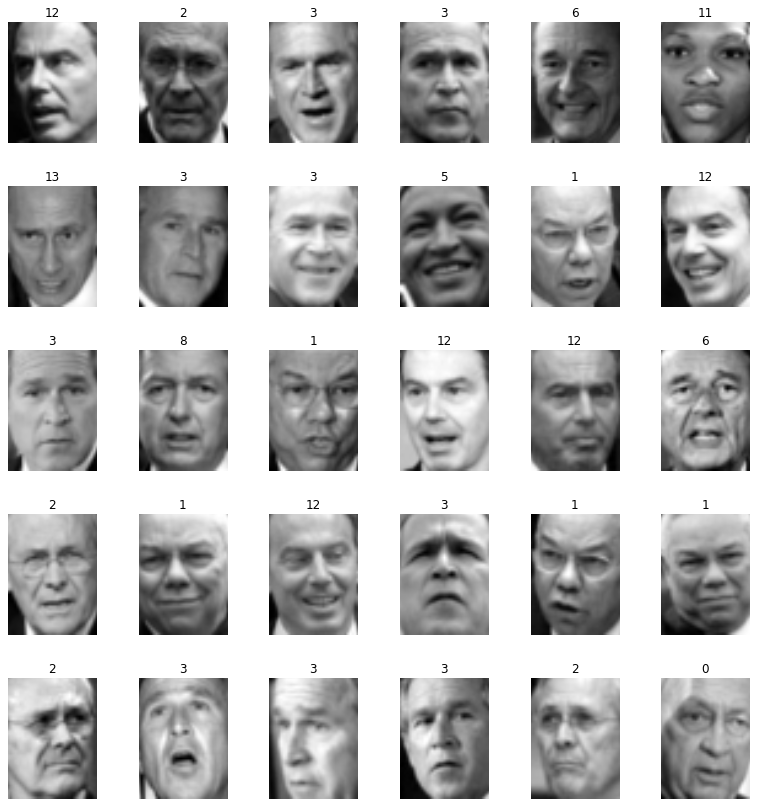

In [8]:
plot_gallery(X, y, h,w)

### Test- train split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

## Principal Component Analysis

The feature space is 1850 dimenstional. It is very computationally intensive to apply any algorithm. So, I am applying a PCA on the given data to keep only the first 150-200 components.

In [10]:
n_components = 50
print("Extracting the top %d eigenfaces from %d faces"
      % (n_components, X_train.shape[0]))
pca = RandomizedPCA(n_components=n_components, whiten=True).fit(X_train)
eigenfaces = pca.components_.reshape((n_components, h, w))
print("Projecting the input data on the eigenfaces orthonormal basis")
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

Extracting the top 50 eigenfaces from 1242 faces
Projecting the input data on the eigenfaces orthonormal basis


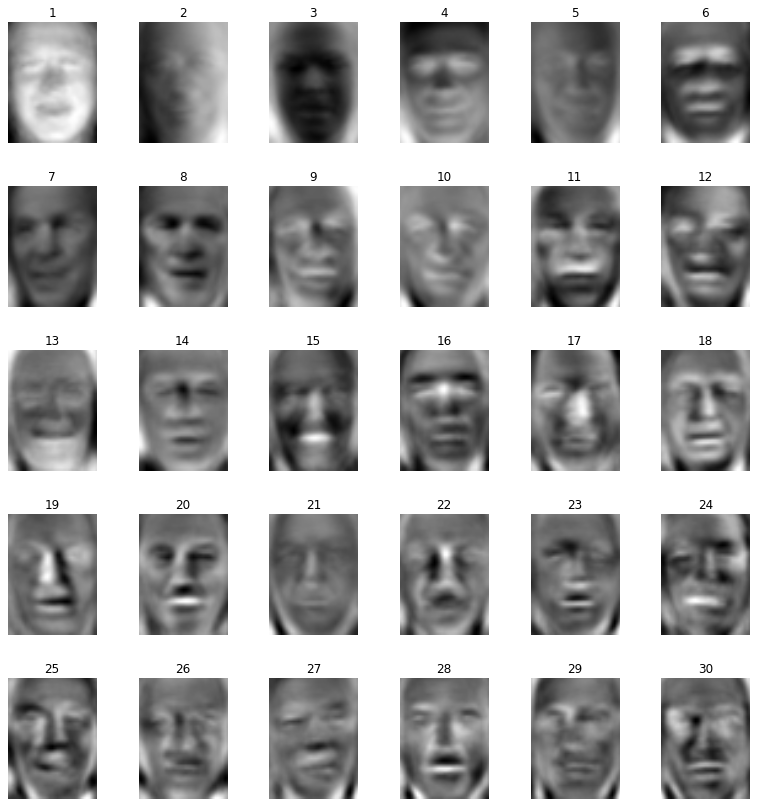

In [11]:
plot_gallery(eigenfaces,range(1,31) , h,w)

When you think about what PCA is actually doing, the first few components in it should represent maximum variance in the data. Surprizingly on image data, we would expect the 1-2 components capture the maximum variance i.e faces in the data. It turns out that the maximum variance in images is typically the brightness or darkness. So, the first few components really doesn't capture anything related to faces, but represents the averaged brightness/darkness in the given data. 

Image segmentation, edge detection or more hand-crafted features might be a better predictors for doing a classification problem. One thing that comes in to my mind is ** Independent Component analysis ** (also taught at Udacity's Machine learning course) finds relevant features for natural images like edges.

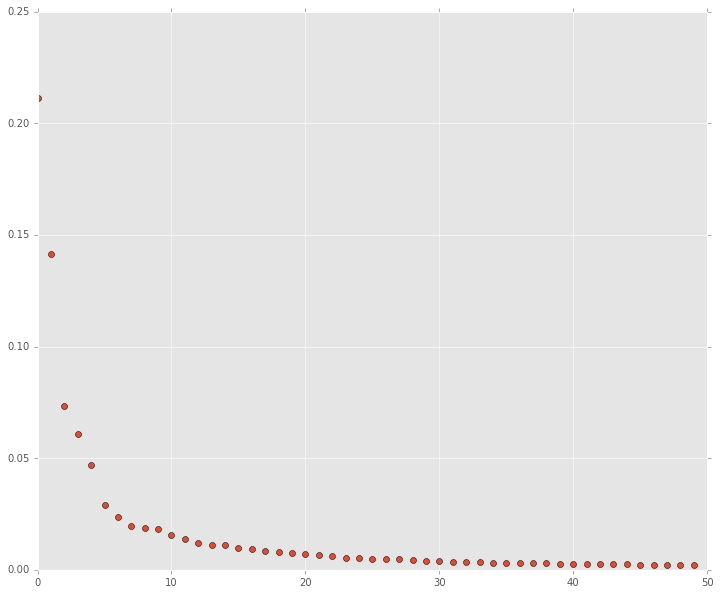

In [15]:
plt.plot(pca.explained_variance_ratio_, 'o')

The first ~50 components does seem to explain most of the variance in the given data. So, I decided to confine PCA to keep only the first fifty components.

## Independent Component Analysis

In [16]:
from sklearn.decomposition import FastICA
n_components =50

In [17]:
ica = FastICA(n_components=n_components, whiten=True).fit(X_train)
icafaces = ica.components_.reshape((n_components, h, w))
X_train_ica = ica.transform(X_train)
X_test_ica = ica.transform(X_test)

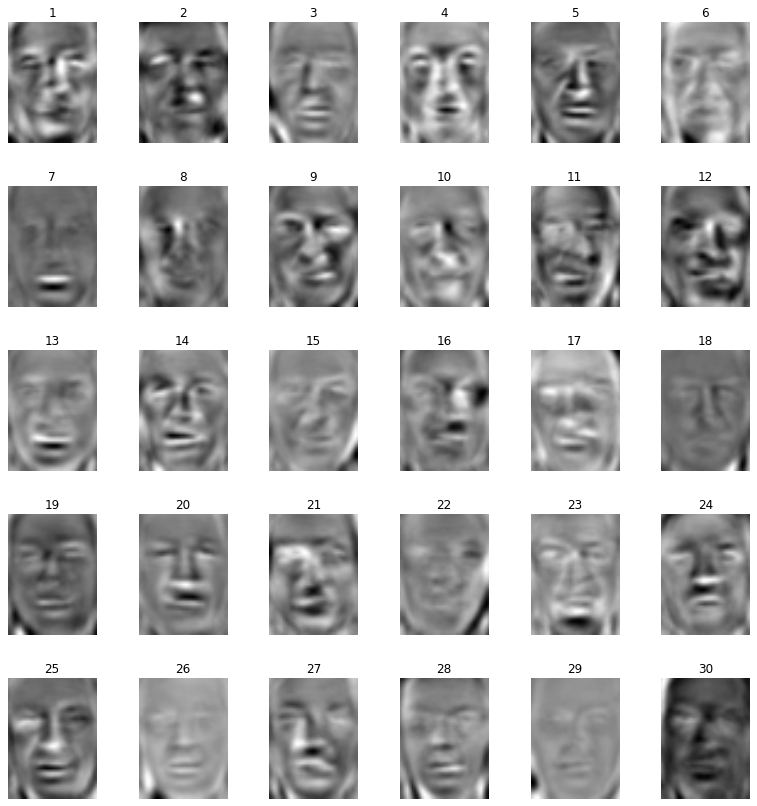

In [18]:
plot_gallery(icafaces,range(1,31) , h,w)

In general, ICA is capturing better features than a PCA. We can see that it is trying to select distinct features in faces like nose, eyes etc. It seems to suggest that ICA would do a better job at classification.

### Visualizing PCA

We can visulaize high dimensional data by using dimensionality reduction techniques. Let's see what we have here.

In [19]:
n_components = 2
print("Extracting the top %d eigenfaces from %d faces"
      % (n_components, X_train.shape[0]))
pca2d = RandomizedPCA(n_components=n_components, whiten=True).fit(X_train)
eigenfaces = pca2d.components_.reshape((n_components, h, w))
print("Projecting the input data on the eigenfaces orthonormal basis")
X_train_pca2d = pca2d.transform(X_train)
X_test_pca2d = pca2d.transform(X_test)

Extracting the top 2 eigenfaces from 1242 faces
Projecting the input data on the eigenfaces orthonormal basis


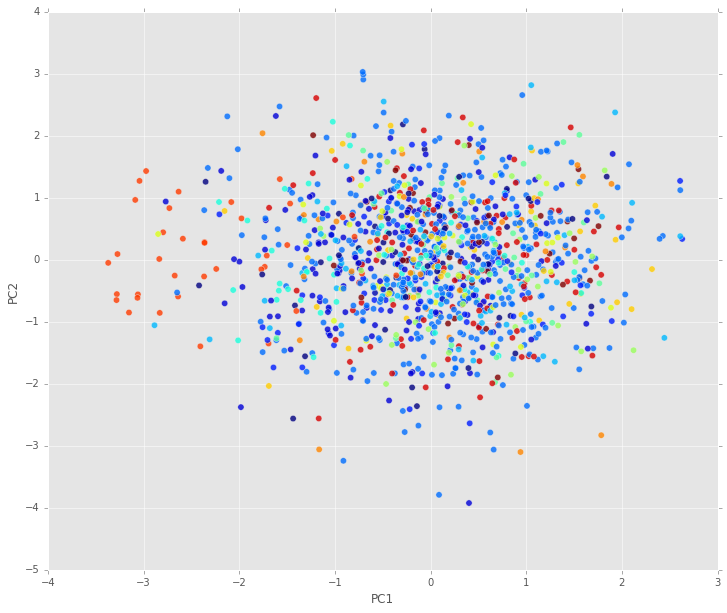

In [20]:
plt.scatter(x= X_train_pca2d[:, 0], y= X_train_pca2d[:,1], marker = 'o',  c=y_train, s=40, alpha=0.8)
plt.xlabel('PC1')
plt.ylabel('PC2')

### Visualizing ICA

In [21]:
n_components = 2
ica2d = FastICA(n_components=n_components, whiten=True).fit(X_train)
icafaces = ica2d.components_.reshape((n_components, h, w))
X_train_ica2d = ica2d.transform(X_train)
X_test_ica2d = ica2d.transform(X_test)

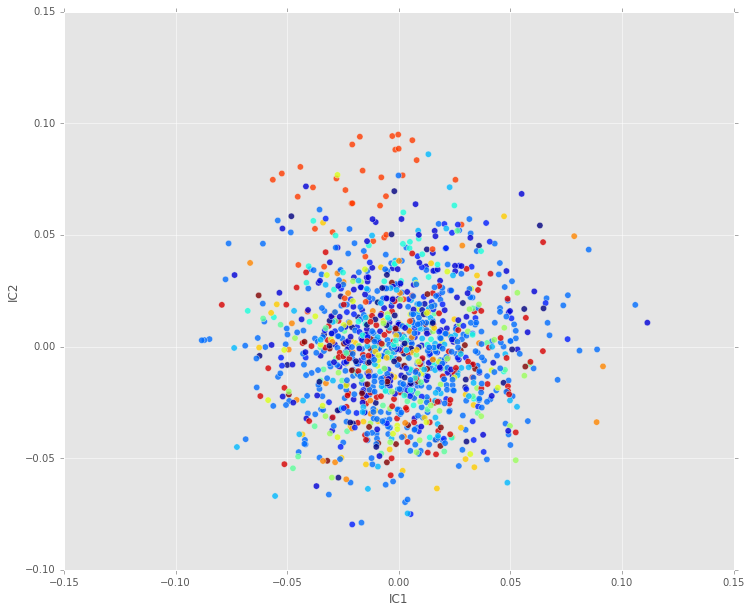

In [22]:
plt.scatter(x= X_train_ica2d[:, 0], y= X_train_ica2d[:,1], marker = 'o',  c=y_train, s=40, alpha=0.8)
plt.xlabel('IC1')
plt.ylabel('IC2')

Jake vanderpals in [his tutorial](https://www.youtube.com/watch?v=L7R4HUQ-eQ0) vouches for manifold learning especially Isomap. You can watch the entire tutorial here, it is definitely worth your time. You can think of Isomaps is a kind of non-linear dimensionality reduction. Nothing showed anything significant on this dataset though.

### Isomaps

In [23]:
from sklearn.manifold import Isomap

In [24]:
iso = Isomap(n_neighbors=5, n_components=2).fit(X_train)
X_train_iso = iso.transform(X_train)
X_test_iso = iso.transform(X_test)

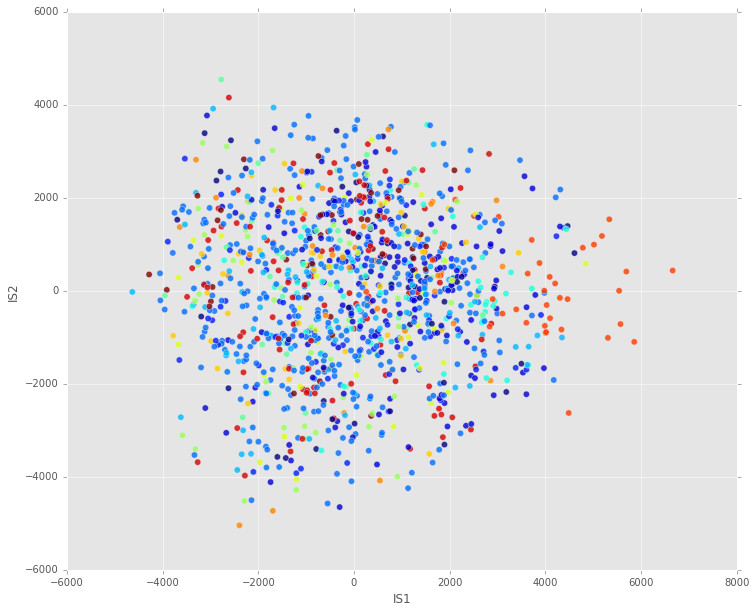

In [25]:
plt.scatter(x= X_train_iso[:, 0], y= X_train_iso[:,1], marker = 'o',  c=y_train, s=40, alpha=0.8)
plt.xlabel('IS1')
plt.ylabel('IS2')

## Support vector machines

Before using SVM's, I have tried decision trees, ensemble methods, random forests and k-nearest neighbors. They showed very poor performance on this dataset.

Support vector machines are a class of methods that try to seperate the training data using hyperplanes. With the so-called kernel trick and a way of controlling using the margin, SVM's can be applied to various classificaton problems.

In [26]:
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(SVC(kernel='rbf'), param_grid, verbose=10, n_jobs=-1)
clf = clf.fit(X_train_pca, y_train)
print("Best estimator found by grid search:")
print(clf.best_estimator_)

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    4.6s finished


Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [27]:
clf = clf.best_estimator_
clf = clf.fit(X_train_pca, y_train)
score = accuracy_score(y_test,clf.predict(X_test_pca))
print score

0.8


In [28]:
y_pred = clf.predict(X_test_pca)
print(classification_report(y_test, y_pred, target_names=target_names))

                           precision    recall  f1-score   support

             Ariel Sharon       0.74      0.61      0.67        23
             Colin Powell       0.79      0.87      0.83        71
          Donald Rumsfeld       0.78      0.62      0.69        29
            George W Bush       0.85      0.92      0.88       132
        Gerhard Schroeder       0.78      0.64      0.71        28
              Hugo Chavez       0.92      0.75      0.83        16
           Jacques Chirac       0.70      0.54      0.61        13
            Jean Chretien       0.60      0.86      0.71         7
            John Ashcroft       0.82      0.90      0.86        10
        Junichiro Koizumi       0.94      0.94      0.94        17
Luiz Inacio Lula da Silva       0.80      0.62      0.70        13
          Serena Williams       0.75      0.86      0.80        14
               Tony Blair       0.74      0.84      0.79        31
           Vladimir Putin       0.33      0.18      0.24     

In [29]:
cm =confusion_matrix(y_test, y_pred, labels=range(n_classes))
cm_normalized = cm.astype('float') / cm.sum(axis=1)

In [30]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

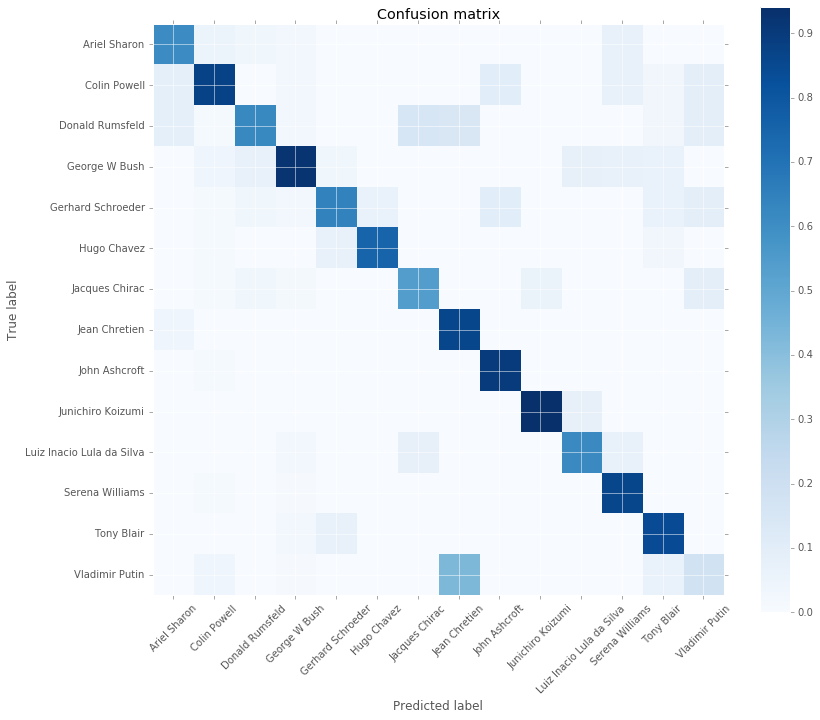

In [31]:
plot_confusion_matrix(cm_normalized)

I was able to obtain close to 80% accuracy on a 14-class classification problem and I think that's very good.

## Conclusion

I've realized that turning a vision problem into a machine learning problem didn't work at all. It seems like neural networks are the state of the art in classifying images. SVM's with RBF kernel and ten fold cross validation revealed that they can do classification with ~80% accuracy. Other than that, everything else I tried didn't give desirable performance. I would like to try a few hand-crafted features like Gabor filters. 